<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/vae-iteration/notebooks/Segmentation_Downstream_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation downstream task: SEN12FLOOD

Model: ResNetUnet \\
Data: SEN12FLOOD \\
Pretrained weights: dependent on pretext tasks



## Data

In [1]:
!pip install rasterio torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 527 kB/s 
     |████████████████████████████████| 529 kB 47.0 MB/s 


In [2]:
import rasterio as rio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import random

SEN12FLOOD \\


*   13 Bands


In [3]:
import gdown

gdown.download('https://drive.google.com/u/1/uc?id=1zGalZSCxgnmZM7zMm0qfRrnOXyD6IUX1&export=download')

Downloading...
From: https://drive.google.com/u/1/uc?id=1zGalZSCxgnmZM7zMm0qfRrnOXyD6IUX1&export=download
To: /content/lab-seg-data.tar.gz
100%|██████████| 5.37G/5.37G [01:12<00:00, 74.3MB/s]


'lab-seg-data.tar.gz'

In [4]:
import tarfile
import os

data_base_path = '/content/'
data_folder = 'lab-seg-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

with tarfile.open(tar_path, mode='r') as tar:
    tar.extractall(path=data_base_path)

In [5]:
class SEN12FLOODS():
    """SEN12FLOODS Segmentation Dataset."""
    def __init__(self, root='chips/', split='train', transforms=None, **kwargs):
        super(SEN12FLOODS, self).__init__()
        
        # Loop over available data and create pairs of Sentinel 1 and Sentinel 2 images, co-registered,
        # with corresponding groundtruth, and store the paths in lists. 
        self.s2_images, self.s2_masks, self.s1_images, self.s1_masks = self._get_sen2flood_pairs(root, split)
        
        # Make sure that for each data point we have all the values we need.
        assert (len(self.s2_images) == len(self.s2_masks) == len(self.s1_images) == len(self.s1_masks))
        if len(self.s2_images) == 0:
            raise RuntimeError("Found 0 images in subfolders of:" + root + "\n")

        print('Found {} images in the folder {}'.format(len(self.s2_images), root  + split))
        
        self.transforms = transforms
        
        # Initialise the data augmentation we will use: horizontal and vertical flipping, random affine translation, resizing
        if self.transforms:
            augmentation = A.Compose(
                [
                    A.Resize(height=256, width=256, p=1, interpolation=cv2.INTER_NEAREST),
                    A.Affine(scale=2, translate_px=5, rotate=20, p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    ToTensorV2()
                ] , additional_targets={'image0': 'image'}
            )
            self.augmentation = augmentation

        else:
            augmentation = A.Compose(
                [
                    A.Resize(height=256, width=256, p=1, interpolation=cv2.INTER_NEAREST),
                    ToTensorV2(),
                ] , additional_targets={'image0': 'image'}
            )
            self.augmentation = augmentation

        # turn lists into arrays
        self.s2_images = np.array(self.s2_images)
        self.s1_images = np.array(self.s1_images)
        self.s2_masks = np.array(self.s2_masks)
        self.s1_masks = np.array(self.s1_masks)

    def __len__(self):
        return len(self.s2_images)

    def __getitem__(self, index):
        # Loop over all bands, and create a concatenated array for sentinel-2 data
        bands = []
        for file in ['B1.tif', 'B2.tif', 'B3.tif', 'B4.tif', 'B5.tif', 'B6.tif', 'B7.tif',
                     'B8.tif', 'B8A.tif', 'B9.tif', 'B10.tif', 'B11.tif', 'B12.tif']:
            band = rio.open(os.path.join(self.s2_images[index], file))
            bands.append(band.read())
        s2_img = np.concatenate(bands, axis=0)
        s2_img = np.array(s2_img, dtype=np.float32)
        #print(s2_img.shape)
        
        # Loop over both polarization, and create a concatenated array for sentinel-1 data
        bands = []
        for file in ['VH.tif', 'VV.tif']:
            band = rio.open(os.path.join(self.s1_images[index], file))
            band_array = band.read()
            if np.isfinite(band_array).all():
                bands.append(band.read())
            else:
                bands.append(np.zeros(band_array.shape))
        s1_img = np.concatenate(bands, axis=0)
        s1_img = np.array(s1_img, dtype=np.float32)
        
        # The two channels of Sentinel-1 (VV and VH) have both negative and positive values. 
        # We normalize them to lie between 0 and 1 by applying [min-max normalization with min = -77 and max = 26.
        s1_img = np.clip(s1_img, a_min=-77, a_max=26)
        s1_img = (s1_img + 77) / (26 + 77)
        
        # The water labels for Sentinel 1 and Sentinel 2 can be slightly different (since scenes are taken around 3 days apart)
        # We read the water label mask associated to Sentinel 2. 
        mask = rio.open(self.s2_masks[index])
        mask_img = mask.read().squeeze()

        # Apply same data augmentation for both sentinel 2 and sentinel 1 images, and the mask.
        augmented_data = self.augmentation(image=np.transpose(s2_img, (1, 2, 0)), image0=np.transpose(s1_img, (1, 2, 0)), mask=mask_img)
        
        # Define output tensor
        output_tensor = {
            "s2_img": augmented_data['image'],
            "s1_img": augmented_data['image0'],
            "s2_imgfile": self.s2_images[index],
            "s1_imgfile": self.s1_images[index],
            "mask": augmented_data['mask'],
            #"mask": np.expand_dims(augmented_data['mask'], axis=0),
        }

        return output_tensor

    def _get_sen2flood_pairs(self, folder, split):
        """
        Constructs Sentinel2 and Sentinel1 pairs

        Arguments
        ----------
            folder : str
                Image folder name 
            split : str
                train or val split
        Returns
        -------
            s2_img_paths : list
                List of Sentinel 2 image path
            s2_mask_paths : list
                List of Sentinel 2 water mask path
            s1_img_paths : list
                List of Sentinel 1 image path
            s1_mask_paths : list 
                List of Sentinel 1 water mask path
        """
        s2_img_paths = []
        s2_mask_paths = []
        s1_img_paths = []
        s1_mask_paths = []

        img_folder = os.path.join(folder, split)
        
        # loop over the image folder (train or validation)
        for filename in os.listdir(img_folder):
            if filename not in ['._.DS_Store', '.DS_Store']:
                for file in os.listdir(os.path.join(img_folder, filename, 's2')):
                    if file not in ['._.DS_Store', '.DS_Store']:
                        # Get the Image ID (as explained in the dataset section)
                        image_id = file.split('_')[-1]
                        
                        # Store Sentinel 2 image and mask paths in lists
                        s2_imgpath = os.path.join(img_folder, filename, 's2', file)
                        s2_maskpath = os.path.join(img_folder, filename, 's2', file, 'LabelWater.tif')
                        
                        # Using the Image ID, store co-registered Sentinel 1 image and mask paths in lists
                        s1_files = os.listdir(os.path.join(img_folder, filename, 's1'))
                        s1_file = [file for file in s1_files if file.endswith(image_id)][0]
                        s1_imgpath = os.path.join(img_folder, filename, 's1', s1_file)
                        s1_maskpath = os.path.join(img_folder, filename, 's1', s1_file, 'LabelWater.tif')
                        
                        if os.path.isfile(s1_maskpath):
                            s2_img_paths.append(s2_imgpath)
                            s2_mask_paths.append(s2_maskpath)
                            s1_img_paths.append(s1_imgpath)
                            s1_mask_paths.append(s1_maskpath)
                        else:
                            print('cannot find the S1 Mask:', s1_maskpath)

        return s2_img_paths, s2_mask_paths, s1_img_paths, s1_mask_paths
    
    def visualize_observation(self, idx):
        """
        Visualise Sentinel1, Sentinel2, and water mask. 

        Arguments
        ----------
            idx : int
                Data index
        """
        sample = self.__getitem__(idx)

        s2_image = sample.get("s2_img").squeeze()
        s1_image = sample.get("s1_img").squeeze()
        mask = sample.get("mask")
        
        print(sample.get('s2_imgfile'))
        print(sample.get('s1_imgfile'))

        fig, axs = plt.subplots(1, 3, figsize=(17, 6))
        
        s1_img_vh = s1_image[0, :, :]
        s1_img_vh = s1_img_vh / s1_img_vh.max()

        axs[0].imshow(s1_img_vh)
        axs[0].set_title("Sentinel-1 VH")
        axs[0].axis('off')
        
        s2_img_rgb = s2_image[[3, 2, 1], :, :]
        s2_img_rgb = np.transpose(s2_img_rgb, (1, 2, 0))
        s2_img_rgb = s2_img_rgb / s2_img_rgb.max()

        axs[1].imshow(s2_img_rgb)
        axs[1].set_title("Sentinel-2 RGB")
        axs[1].axis('off')

        mask = mask.squeeze()

        axs[2].imshow(mask, cmap='Blues')
        axs[2].set_title("Groundtruth Mask")
        axs[2].axis('off')

        plt.show()

In [6]:
trainset = SEN12FLOODS(
        root='/content/chips/',
        transforms=True,
        split='train')

valset = SEN12FLOODS(
    root='/content/chips/', 
    split='val')


train_loader = DataLoader(
    trainset,
    batch_size=8,
    pin_memory=True)

val_loader = DataLoader(
    valset,
    batch_size=8,
    pin_memory=True)

Found 688 images in the folder /content/chips/train
Found 211 images in the folder /content/chips/val


In [7]:
next(iter(train_loader))["mask"].shape

torch.Size([8, 256, 256])

In [8]:
next(iter(train_loader))["s2_img"].shape

torch.Size([8, 13, 256, 256])

/content/chips/train/749aca10-a39b-4321-8322-100dd6f976d4/s2/S2B_MSIL1C_20190214T004709_N0207_R102_T54KVF_20190214T020418_05120-04608
/content/chips/train/749aca10-a39b-4321-8322-100dd6f976d4/s1/S1B_IW_GRDH_1SDV_20190215T090752_20190215T090826_014954_01BECA_6119_05120-04608


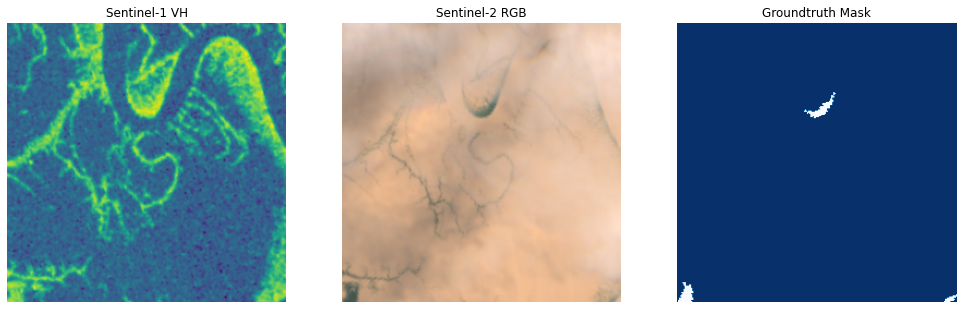

In [9]:
trainset.visualize_observation(95)

## Load pretext weights

In [13]:
import os
import torch

def best_model_loader(pretext_model,pretext_model_dir,pretext_model_path):

    # restore pre-trained model snapshot
    best_model_name = os.path.join(pretext_model_dir, pretext_model_path)

    # load state_dict from path
    state_dict_best = torch.load(best_model_name, map_location=torch.device('cpu'))

    # init pre-trained model class
    best_model = pretext_model

    # load pre-trained models
    best_model.load_state_dict(state_dict_best)

    return best_model

In [ ]:
#best_model = best_model_loader(autoencoder,"./weights/","autoencoder.pkl")

In [ ]:
# best_model_encoder = best_model.encoder()

In [14]:
# test model of pretrained resnet18 model ()
import torchvision
best_model_encoder = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [15]:
from copy import deepcopy
bst_encoder = deepcopy(best_model_encoder)

In [26]:
# funciton to change first convolution layer input channels => make random kaiming normal initialization

def patch_first_conv(encoder, new_in_channels, default_in_channels=3):

    for module in encoder.modules():
        if isinstance(module, nn.Conv2d) and module.in_channels == 3:
            print("Module to be convoluted: ", module)
            break

    weight = module.weight.detach()
    module.in_channels = new_in_channels         

    new_weight = torch.Tensor(module.out_channels, new_in_channels // module.groups, *module.kernel_size)
    for i in range(new_in_channels):
        new_weight[:, i] = weight[:, i % default_in_channels]

    new_weight = new_weight * (default_in_channels / new_in_channels)
    module.weight = nn.parameter.Parameter(new_weight)

    # make sure in_channel is changed
    assert module.in_channels == new_in_channels

In [27]:
patch_first_conv(bst_encoder,13,default_in_channels=3)

Module to be convoluted:  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


## Model

Resnet18 Unet

In [28]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class,encoder = None):
    super().__init__()
    
    # test base mode: pretrained resnet 18 of imagenet
    #self.base_model = torchvision.models.resnet18(pretrained=True)
    # base model from our pre-trained model
    # patch_first_conv
    self.base_model = encoder
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    # from 3 to 13
    self.conv_original_size0 = convrelu(13, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    # concat: skip connection to merge features from z_layer3
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    # concat: skip connection to merge features from z_layer2
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    # concat: skip connection to merge features from z_layer1
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [49]:
# class = 1
model = ResNetUNet(1,encoder = bst_encoder)

In [50]:
# # freeze backbone layers
# for l in model.base_layers:
#   for param in l.parameters():
#     param.requires_grad = False

In [51]:
# model

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

In [53]:
# from torchsummary import summary
# summary(model.to(device), input_size=(13, 256, 256))

## Training

In [54]:
# Define a learning rate
learning_rate = 0.001

# Initialise the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
# Initialise the loss function and move it to the GPU if available 
criterion = torch.nn.BCEWithLogitsLoss().to(device)

In [56]:
next(iter(train_loader))["s2_img"].shape

torch.Size([8, 13, 256, 256])

In [57]:
if not os.path.exists('./weights'):
    os.mkdir('./weights')

In [58]:
# We will use the tqdm library to display the progress of our training. 
# from tqdm.autonotebook import tqdm
from tqdm import tqdm
from torchmetrics import JaccardIndex
import os

# Move the model to the GPU
model.to(device)

# Create lists for logging losses and evalualtion metrics:
train_losses = []
train_accs = []
train_ious = []

val_losses = []
val_accs = []
val_ious = []

# IoU
jaccard = JaccardIndex(num_classes=2).to(device)


# For every epoch 
for epoch in range(70):
    epoch_loss = 0
    progress = tqdm(
        enumerate(train_loader), desc="Train Loss: ",
        total=len(train_loader)
    )
    
    # Specify you are in training mode
    model.train()
    
    epoch_train_loss = 0
    epoch_val_loss = 0

    epoch_train_ious = 0
    epoch_val_ious = 0

    epoch_train_accs = 0
    epoch_val_accs = 0

    for i, batch in progress:
        # Transfer data to GPU if available
        data = batch["s2_img"].float().to(device)
        label = batch['mask'].float().to(device)
        
        # Make a forward pass
        output = model(data)
        #print(output.shape)

        # Derive binary segmentation map from prediction
        output_binary = torch.zeros(output.shape)
        output_binary[output >= 0] = 1

        # Compute IoU
        epoch_train_ious += jaccard(output_binary.to(device), label.int()) / len(train_loader)

        # Compute pixel accuracies
        epoch_train_accs += torch.sum(output_binary.to(device) == label.int()) / (len(train_loader) * (256*256) * 100)
        
        # Compute the loss
        loss = criterion(output, label.unsqueeze(1))
        
        # Clear the gradients
        optimizer.zero_grad()

        # Calculate gradients 
        loss.backward()

        # Update Weights
        optimizer.step()
        
        # Accumulate the loss over the eopch
        epoch_train_loss += loss / len(train_loader)

        progress.set_description("Epoch = {}, Train Loss: {:.4f}".format(epoch+1,
                                     epoch_train_loss))

    progress = tqdm(
        enumerate(val_loader), desc="val Loss: ",
        total=len(val_loader), position=0, leave=True,)
    
    # Specify you are in evaluation mode
    model.eval()
    
    # Deactivate autograd engine (no backpropagation allowed)
    with torch.no_grad():
        epoch_val_loss = 0
        for j, batch in progress:
            # Transfer Data to GPU if available
            data = batch["s2_img"].float().to(device)
            label = batch['mask'].float().to(device)

            # Make a forward pass
            output = model(data)

            # Derive binary segmentation map from prediction
            output_binary = torch.zeros(output.shape)
            output_binary[output >= 0] = 1

            # Compute IoU
            epoch_val_ious += jaccard(output_binary.to(device), label.int()) / len(val_loader)

            # Compute pixel accuracies
            epoch_val_accs += torch.sum(output_binary.to(device) == label.int()) / (len(val_loader) * (256*256) * 100)
            
            # Compute the loss
            val_loss = criterion(output, label.unsqueeze(1))
                    
            # Accumulate the loss over the epoch
            epoch_val_loss += val_loss / len(val_loader)

            progress.set_description("Validation Loss: {:.4f}".format(
                                     epoch_val_loss))
    
    if epoch == 0:
        best_val_loss = epoch_val_loss
    else:
        if epoch_val_loss <= best_val_loss:
            best_val_loss = epoch_val_loss
            # Save only the best model
            save_weights_path = "./weights/segmentation_model.pth"
            torch.save(model.state_dict(), save_weights_path)
            print('Saving Model...')

    # print("Epoch = ", epoch+1)
    # Save losses in list, so that we can visualise them later. 
    train_losses.append(epoch_train_loss.cpu().detach().numpy())
    val_losses.append(epoch_val_loss.cpu().detach().numpy())

    # Save IoUs in list, so that we can visualise them later. 
    train_ious.append(epoch_train_ious.cpu().detach().numpy())
    val_ious.append(epoch_val_ious.cpu().detach().numpy())
    print(f'train_iou is {epoch_train_ious:.4f}, val_iou is {epoch_val_ious:.4f}')

    # Save accuracies in list, so that we can visualise them later. 
    train_accs.append(epoch_train_accs.cpu().detach().numpy())
    val_accs.append(epoch_val_accs.cpu().detach().numpy())
    print(f'train_acc is {epoch_train_accs:.4f}, val_acc is {epoch_val_accs:.4f}')

print('Finished Training')

Validation Loss: 0.1878: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


train_iou is 0.6012, val_iou is 0.7907
train_acc is 0.5260, val_acc is 0.4964


Validation Loss: 0.1258: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


Saving Model...
train_iou is 0.7041, val_iou is 0.8020
train_acc is 0.5454, val_acc is 0.4930


Validation Loss: 0.1276: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7673, val_iou is 0.8028
train_acc is 0.5416, val_acc is 0.4975


Validation Loss: 0.1646: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


train_iou is 0.7624, val_iou is 0.8127
train_acc is 0.5424, val_acc is 0.4821


Epoch = 5, Train Loss: 0.1081:  76%|███████▌  | 65/86 [01:06<00:21,  1.02s/it]


KeyboardInterrupt: ignored

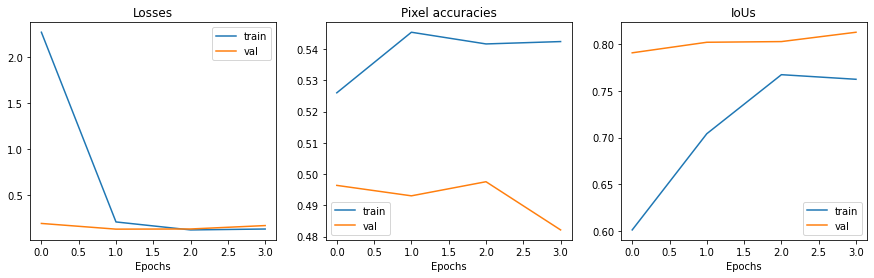

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(train_losses, label='train')
axes[0].plot(val_losses, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_title('Losses')
axes[0].legend()

axes[1].plot(train_accs, label='train')
axes[1].plot(val_accs, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_title('Pixel accuracies')
axes[1].legend()

axes[2].plot(train_ious, label='train')
axes[2].plot(val_ious, label='val')
axes[2].set_xlabel('Epochs')
axes[2].set_title('IoUs')
axes[2].legend()

In [60]:
# Initialise a UNet() model 
#ResNetUNet(1,encoder = best_model.encoder)
ResNetUNet(1,encoder = torchvision.models.resnet18(pretrained=True))
# Load pretrained weights
model.load_state_dict(torch.load('./weights/segmentation_model.pth'))
# Move to device (GPU or CPU)
model.to(device);

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [61]:
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score

def get_metrics(true, preds):
    matrix = confusion_matrix(true.flatten(), preds.flatten())
    class_0, class_1 = matrix.diagonal() / matrix.sum(axis=1)
    print('***************** Metrics *****************')
    print('Class 0 (no water) accuracy: {:.3f}'.format(class_0))
    print('Class 1 (water) accuracy: {:.3f}'.format(class_1))
    print('Overall accuracy: {:.3f}'.format(accuracy_score(true.flatten(), preds.flatten())))
    print('Equally Weighted accuracy: {:.3f}'.format(0.5 * class_0 + 0.5 * class_1))
    print('IoU: {:.3f}'.format(jaccard_score(true.flatten(), preds.flatten())))
    print('*******************************************')

In [62]:
def display_outputs(idx=None, multi=False):
    # Pick a random index if none is specified
    if not idx:
        idx = random.randint(0, len(valset))
    print('Validation image ID: {}'.format(idx))
    
    # Get Sentinel 2 and Sentinel 1 data
    s2_data = torch.unsqueeze(valset.__getitem__(idx)['s2_img'].float().to(device), 0)
    s1_data = torch.unsqueeze(valset.__getitem__(idx)['s1_img'].float().to(device), 0)
    
    # Get predictions from the model
    if multi:
        output = model(s1_data, s2_data)
    else:
        output = model(s2_data)
    
    # Threshold the output to generate the binary map (FYI: the threshold value "0" can be tuned as any other hyperparameter)
    output_binary = torch.zeros(output.shape)
    output_binary[output >= 0] = 1
    
    get_metrics(valset.__getitem__(idx)['mask'], output_binary)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    axes[0].imshow(np.transpose(valset.__getitem__(idx)['s2_img'][[3,2,1],:,:], (1, 2, 0)) / valset.__getitem__(idx)['s2_img'].max())
    axes[0].set_title('True Color Sentinel-2')
    axes[2].imshow(valset.__getitem__(idx)['mask'], cmap='Blues')
    axes[2].set_title('Groundtruth')
    axes[1].imshow(output_binary.squeeze(), cmap='Blues')
    axes[1].set_title('Predicted Mask')

Validation image ID: 204
***************** Metrics *****************
Class 0 (no water) accuracy: 0.998
Class 1 (water) accuracy: 0.298
Overall accuracy: 0.993
Equally Weighted accuracy: 0.648
IoU: 0.240
*******************************************


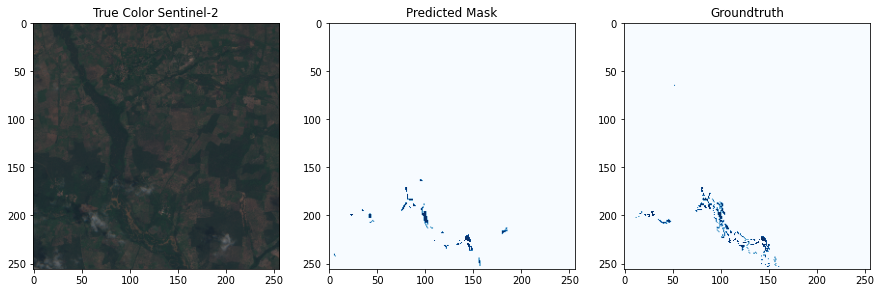

In [63]:
display_outputs()

## Model Fusion

In [68]:
from copy import deepcopy
bst_encoder_sentinel1 = deepcopy(best_model_encoder)

In [69]:
patch_first_conv(bst_encoder_sentinel1,2,default_in_channels=3)

Module to be convoluted:  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [88]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet_Sentinel1(nn.Module):
  # remove n_classes
  def __init__(self,encoder = None):
    super().__init__()
    
    # base model from our pre-trained model
    # TODO: needs to add representations from different base model (Z1, Z2)
    self.base_model = encoder
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(2, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    # remove last convolution block
    # self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    # concat: skip connection to merge features from z_layer3
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    # concat: skip connection to merge features from z_layer2
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    # concat: skip connection to merge features from z_layer1
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)
    
    # remove last convolution block
    # out = self.conv_last(x)

    return x

In [89]:
class ResNetUNet_Sentinel2(nn.Module):
  # remove n_classes
  def __init__(self,encoder = None):
    super().__init__()
    
    # base model from our pre-trained model
    # TODO: needs to add representations from different base model (Z1, Z2)
    self.base_model = encoder
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(13, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    # remove last convolution block
    # self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    # concat: skip connection to merge features from z_layer3
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    # concat: skip connection to merge features from z_layer2
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    # concat: skip connection to merge features from z_layer1
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)
    
    # remove last convolution block
    # out = self.conv_last(x)

    return x

In [90]:
class DualResNetUNet(nn.Module):
    def __init__(self, n_classes):
        super(DualResNetUNet, self).__init__()
        
        # First stream of UNet() for Sentinel 1 data (in_channels_1 = 2)
        self.unet1 = ResNetUNet_Sentinel1(bst_encoder_sentinel1)
        # Second stream of UNet() for Sentinel 2 data (in_channels_2 = 13)
        self.unet2 = ResNetUNet_Sentinel2(bst_encoder)
        
        # Output convolution
        self.outc = nn.Conv2d(2*64, n_classes, 1)

    def forward(self, x1, x2):
        # We process Sentinel1 input
        x1 = self.unet1(x1)
        # We process Sentinel2 input
        x2 = self.unet2(x2)
        
        # We concatenate the two representations
        x = torch.cat([x1, x2], dim=1)
        
        # We feed the fused representation to the output convolution
        x = self.outc(x)
        
        return x

In [91]:
model = DualResNetUNet(1)

In [92]:
print("Device used: {}".format(device))
model = model.to(device)

Device used: cuda


In [93]:
# model

In [94]:
from torchsummary import summary
summary(model, input_size=[(2, 256, 256),(13, 256, 256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,216
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]           6,272
            Conv2d-6         [-1, 64, 128, 128]           6,272
       BatchNorm2d-7         [-1, 64, 128, 128]             128
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
             ReLU-10         [-1, 64, 128, 128]               0
        MaxPool2d-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
           Conv2d-14           [-1, 64,

In [96]:
# We will use the tqdm library to display the progress of our training. 
# from tqdm.autonotebook import tqdm
from torchmetrics import JaccardIndex
from tqdm import tqdm

# Move the model to the GPU
model.to(device)

# Create lists for logging losses and evalualtion metrics:
train_losses = []
train_accs = []
train_ious = []

val_losses = []
val_accs = []
val_ious = []

jaccard = JaccardIndex(num_classes=2).to(device)

# For every epoch 
for epoch in range(4):
    epoch_loss = 0
    progress = tqdm(
        enumerate(train_loader), desc="Train Loss: ",
        total=len(train_loader)
    )
    
    # Specify you are in training mode
    model.train()
    
    epoch_train_loss = 0
    epoch_val_loss = 0

    epoch_train_ious = 0
    epoch_val_ious = 0

    epoch_train_accs = 0
    epoch_val_accs = 0

    for i, batch in progress:
        # Transfer data to GPU if available
        s2_data = batch["s2_img"].float().to(device)
        s1_data = batch["s1_img"].float().to(device)
        label = batch['mask'].float().to(device)

        # Make a forward pass
        # TODO: s1, s2 dimension to be consistent with contrastive pretext task
        # currently, the size of two inputs are (3,256,256) and (3,256,256)
        output = model(s1_data, s2_data)

        # Derive binary segmentation map from prediction
        output_binary = torch.zeros(output.shape)
        output_binary[output >= 0] = 1

        # Compute IoU
        epoch_train_ious += jaccard(output_binary.to(device), label.int()) / len(train_loader)

        # Compute pixel accuracies
        epoch_train_accs += torch.sum(output_binary.to(device) == label.int()) / (len(train_loader) * (256*256) * 100)
        
        # Compute the loss
        loss = criterion(output, label.unsqueeze(1))
        
        # Clear the gradients
        optimizer.zero_grad()

        # Calculate gradients 
        loss.backward()

        # Update Weights
        optimizer.step()
        
        # Accumulate the loss over the eopch
        epoch_train_loss += loss / len(train_loader)

        progress.set_description("Epoch= {}, Train Loss: {:.4f}".format(epoch+1,
                                     epoch_train_loss))


    progress = tqdm(
        enumerate(val_loader), desc="val Loss: ",
        total=len(val_loader)
    )
    
    # Specify you are in evaluation mode
    model.eval()
    
    # Deactivate autograd engine (no backpropagation allowed)
    with torch.no_grad():
        epoch_val_loss = 0
        for i, batch in progress:
            # Transfer data to GPU if available
            s2_data = batch["s2_img"].float().to(device)
            s1_data = batch["s1_img"].float().to(device)
            label = batch['mask'].float().to(device)

            data = torch.cat([s2_data, s1_data], dim=1).to(device)

            # Make a forward pass
            output = model(s1_data, s2_data)

            # Derive binary segmentation map from prediction
            output_binary = torch.zeros(output.shape)
            output_binary[output >= 0] = 1

            # Compute IoU
            epoch_val_ious += jaccard(output_binary.to(device), label.int()) / len(val_loader)

            # Compute pixel accuracies
            epoch_val_accs += torch.sum(output_binary.to(device) == label.int()) / (len(val_loader) * (256*256) * 100)
            
            # Compute the loss
            val_loss = criterion(output, label.unsqueeze(1))

            # Accumulate the loss over the epoch
            epoch_val_loss += val_loss / len(val_loader)

            progress.set_description("Validation Loss: {:.4f}".format(
                                     epoch_val_loss))
    if epoch == 0:
        best_val_loss = epoch_val_loss
    else:
        if epoch_val_loss <= best_val_loss:
            best_val_loss = epoch_val_loss
            # Save model
            save_weights_path = "./weights/segmentation_model_late_fusion.pth"
            torch.save(model.state_dict(), save_weights_path)
            print('Saving Model...')

    # Save losses in list, so that we can visualise them later. 
    train_losses.append(epoch_train_loss.cpu().detach().numpy())
    val_losses.append(epoch_val_loss.cpu().detach().numpy())

    # Save IoUs in list, so that we can visualise them later. 
    train_ious.append(epoch_train_ious.cpu().detach().numpy())
    val_ious.append(epoch_val_ious.cpu().detach().numpy())
    print(f'train_iou is {epoch_train_ious:.4f}, val_iou is {epoch_val_ious:.4f}')

    # Save accuracies in list, so that we can visualise them later. 
    train_accs.append(epoch_train_accs.cpu().detach().numpy())
    val_accs.append(epoch_val_accs.cpu().detach().numpy())
    print(f'train_acc is {epoch_train_accs:.4f}, val_acc is {epoch_val_accs:.4f}')
    
    
print('Finished Training')
print('Saving Model...')

Validation Loss: 8.4040: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


train_iou is 0.1319, val_iou is 0.1081
train_acc is 0.2137, val_acc is 0.2027


Validation Loss: 8.3990: 100%|██████████| 27/27 [00:26<00:00,  1.04it/s]


Saving Model...
train_iou is 0.1326, val_iou is 0.1081
train_acc is 0.2134, val_acc is 0.2028


Epoch= 3, Train Loss: 3.0898:  43%|████▎     | 37/86 [00:48<01:04,  1.32s/it]


KeyboardInterrupt: ignored

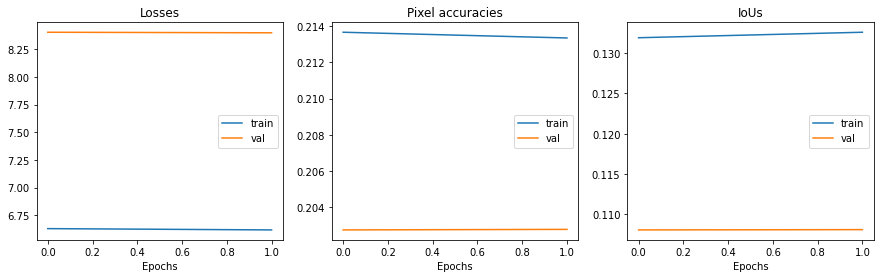

In [97]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(train_losses, label='train')
axes[0].plot(val_losses, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_title('Losses')
axes[0].legend()

axes[1].plot(train_accs, label='train')
axes[1].plot(val_accs, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_title('Pixel accuracies')
axes[1].legend()

axes[2].plot(train_ious, label='train')
axes[2].plot(val_ious, label='val')
axes[2].set_xlabel('Epochs')
axes[2].set_title('IoUs')
axes[2].legend()

In [102]:
# Initialise a UNet() model 
model = DualResNetUNet(1)
# Load pretrained weights
model.load_state_dict(torch.load("./weights/segmentation_model_late_fusion.pth"))
# Move to device (GPU or CPU)
model.to(device);

In [103]:
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score

def get_metrics(true, preds):
    matrix = confusion_matrix(true.flatten(), preds.flatten())
    class_0, class_1 = matrix.diagonal() / matrix.sum(axis=1)
    print('***************** Metrics *****************')
    print('Class 0 (no water) accuracy: {:.3f}'.format(class_0))
    print('Class 1 (water) accuracy: {:.3f}'.format(class_1))
    print('Overall accuracy: {:.3f}'.format(accuracy_score(true.flatten(), preds.flatten())))
    print('Equally Weighted accuracy: {:.3f}'.format(0.5 * class_0 + 0.5 * class_1))
    print('IoU: {:.3f}'.format(jaccard_score(true.flatten(), preds.flatten())))
    print('*******************************************')

In [106]:
def display_outputs(idx=None, multi=False):
    # Pick a random index if none is specified
    if not idx:
        idx = random.randint(0, len(valset))
    print('Validation image ID: {}'.format(idx))
    
    # Get Sentinel 2 and Sentinel 1 data
    s2_data = torch.unsqueeze(valset.__getitem__(idx)['s2_img'].float().to(device), 0)
    s1_data = torch.unsqueeze(valset.__getitem__(idx)['s1_img'].float().to(device), 0)
    
    # Get predictions from the model
    if multi:
        output = model(s1_data, s2_data)
    else:
        output = model(s2_data)
    
    # Threshold the output to generate the binary map (FYI: the threshold value "0" can be tuned as any other hyperparameter)
    output_binary = torch.zeros(output.shape)
    output_binary[output >= 0] = 1
    
    get_metrics(valset.__getitem__(idx)['mask'], output_binary)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    axes[0].imshow(np.transpose(valset.__getitem__(idx)['s2_img'][[3, 2, 1], :, :], (1, 2, 0)) / valset.__getitem__(idx)['s2_img'][[3, 2, 1], :, :].max())
    axes[0].set_title('True Color Sentinel-2')
    axes[2].imshow(valset.__getitem__(idx)['mask'], cmap='Blues')
    axes[2].set_title('Groundtruth')
    axes[1].imshow(output_binary.squeeze(), cmap='Blues')
    axes[1].set_title('Predicted Mask')

Validation image ID: 140
***************** Metrics *****************
Class 0 (no water) accuracy: 0.059
Class 1 (water) accuracy: 0.396
Overall accuracy: 0.067
Equally Weighted accuracy: 0.228
IoU: 0.010
*******************************************


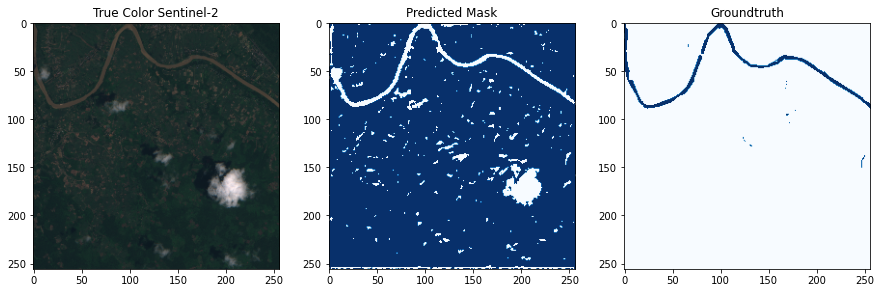

In [108]:
display_outputs(multi = True)